# Image adjustment methods tested

In [ ]:
!pip install numpy opencv-python

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Retinex algorithm

**Process Overview:**

  - **Single Scale Retinex Color Correction:**
    - Enhances image quality while preserving color fidelity.
    - Separates the input image into albedo (color) and illumination components.

  - **Albedo and Illumination Separation:**
    - Decomposes the image to its albedo and illumination parts.
  
  - **Albedo Enhancement:**
    - Applies Single Scale Retinex algorithm to enhance albedo.
    - Utilizes Gaussian blur on the logarithmically transformed image.
  
  - **Combining Albedo and Illumination:**
    - Combines enhanced albedo with the illumination component.
    - Produces a final corrected image while preserving original illumination.


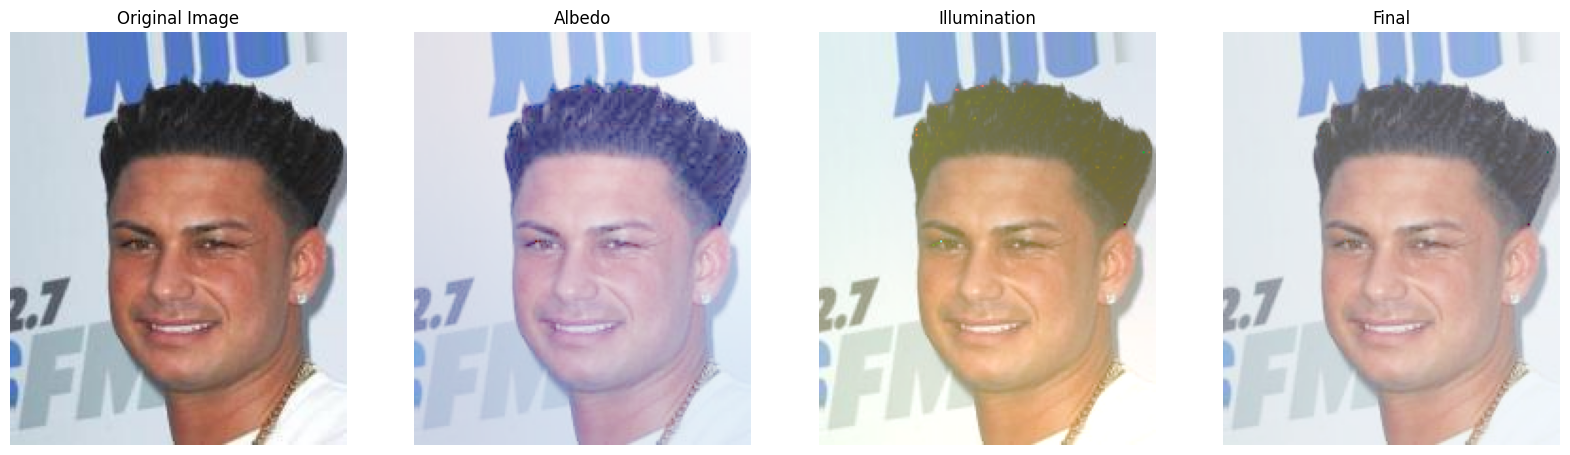

In [ ]:
def single_scale_retinex_color(img, sigma):
    channels = cv2.split(img)
    retinex_channels = []
    for channel in channels:
        tmp_channel = np.float64(channel) + 1.0
        channel_log = np.log(tmp_channel)
        gaussian = cv2.GaussianBlur(channel_log, (0, 0), sigma)
        retinex = channel_log - gaussian
        retinex = (retinex - np.min(retinex)) / (np.max(retinex) - np.min(retinex)) * 255
        retinex_channels.append(retinex)
    retinex_img = cv2.merge(retinex_channels)
    return np.uint8(retinex_img)

def display_images_with_labels(images, labels):
    plt.figure(figsize=(20, 10))
    for i, (image, label) in enumerate(zip(images, labels), 1):
        plt.subplot(1, len(images), i)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(label)
        plt.axis('off')
    plt.show()

def separate_and_display_albedo_illumination(image_path, sigma=80):
    img = cv2.imread(image_path)
    if img is None:
        print("Error loading image")
        return

    albedo = single_scale_retinex_color(img, sigma)
    illumination = cv2.divide(img, cv2.add(albedo, 1), scale=255)
    combined = cv2.addWeighted(albedo, 0.5, illumination, 0.5, 0)

    display_images_with_labels(
        [img, albedo, illumination, combined],
        ['Original Image', 'Albedo', 'Illumination', 'Final']
    )

separate_and_display_albedo_illumination('000187.jpg')


## Averaging

**Process Overview:**

  - **Skin Color Adjustment:**
    - Analyzes the input image to adjust skin color tones.

  - **Image Loading and Preprocessing:**
    - Loads the input image and converts it to floating point format.
  
  - **Mean Color Calculation:**
    - Calculates the mean intensity of red (R), green (G), and blue (B) channels.
  
  - **Color Adjustment:**
    - Adjusts each channel intensity proportionally to match the mean intensity.
  
  - **Clipping and Conversion:**
    - Clips pixel values to ensure they are within the valid range (0-1).
    - Converts the adjusted image back to 8-bit unsigned integer format.


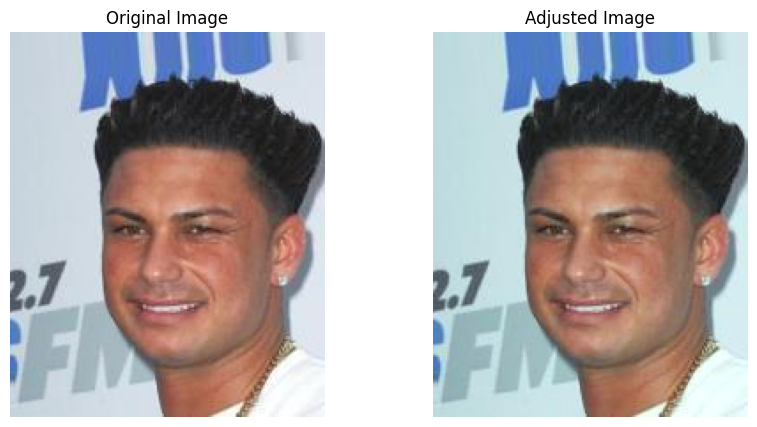

In [ ]:
def adjust_skin_color(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Error loading image")
        return None, None

    image_float = np.float32(image) / 255.0
    mean_r = np.mean(image_float[:, :, 2])
    mean_g = np.mean(image_float[:, :, 1])
    mean_b = np.mean(image_float[:, :, 0])

    mean_intensity = (mean_r + mean_g + mean_b) / 3.0

    image_float[:, :, 2] = np.clip(image_float[:, :, 2] * (mean_intensity / mean_r), 0, 1)
    image_float[:, :, 1] = np.clip(image_float[:, :, 1] * (mean_intensity / mean_g), 0, 1)
    image_float[:, :, 0] = np.clip(image_float[:, :, 0] * (mean_intensity / mean_b), 0, 1)

    adjusted_image = np.uint8(image_float * 255)

    return image, adjusted_image

def show_images(original, adjusted):
    if original is not None and adjusted is not None:
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(adjusted, cv2.COLOR_BGR2RGB))
        plt.title('Adjusted Image')
        plt.axis('off')

        plt.show()

original_img, adjusted_img = adjust_skin_color('000187.jpg')
show_images(original_img, adjusted_img)


## Gray world assumption

**Process Overview:**

  - **Applying Gray World Assumption:**
    - Corrects the color balance of an image using the Gray World Assumption.
  
  - **Image Loading and Preprocessing:**
    - Loads the input image and converts it to floating point format.
  
  - **Calculating Average Color:**
    - Calculates the average color intensity across all pixels.
    - Averages the color intensity per channel (R, G, B) to obtain the overall average color.
    - Reverses the order of the color channels to match OpenCV's BGR convention.
  
  - **Applying Scale Factor:**
    - Computes a scale factor for each channel based on the Gray World Assumption.
    - Divides the ideal target color (0.5 for each channel) by the average color, avoiding division by zero where necessary.
  
  - **Color Correction:**
    - Adjusts each pixel's color intensities by multiplying it with the corresponding scale factor.
    - Clips the pixel values to ensure they are within the valid range (0-1).
    - Converts the corrected image back to 8-bit unsigned integer format.

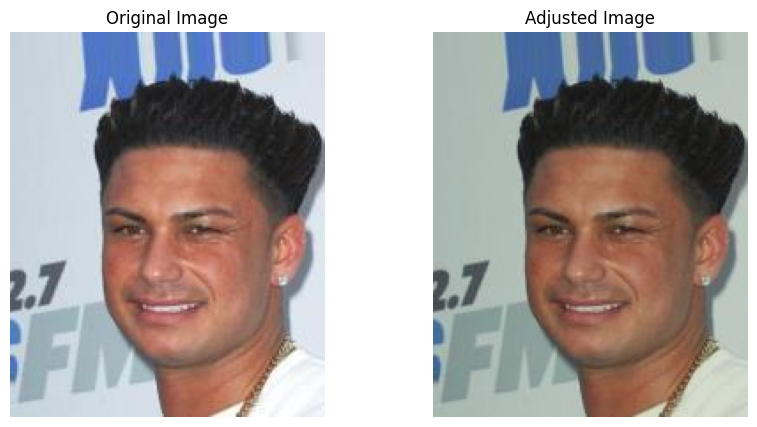

In [ ]:
def apply_gray_world_assumption(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Error loading image")
        return

    img_float = np.float32(img) / 255.0

    avg_color_per_row = np.average(img_float, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    avg_color = avg_color[::-1]

    scale_factor = np.divide([0.5, 0.5, 0.5], avg_color, out=np.zeros_like(avg_color), where=avg_color!=0)

    img_corrected = np.multiply(img_float, scale_factor)
    img_corrected = np.clip(img_corrected, 0, 1)
    img_corrected = (img_corrected * 255).astype(np.uint8)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_corrected, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Adjusted Image')

    plt.show()

apply_gray_world_assumption('000187.jpg')
